### 1. Import e-mail data

In [ ]:
import os, sys
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt, load_imdb
from torch_geometric.transforms import ToUndirected

data = load_hetero_pt()

data = ToUndirected()(data)

### 1.1 Only keep certain nodes for training purposes

In [ ]:
keep = ['email', 'sender', 'url', 'domain', 'stem', 'body_cluster', 'email_domain', 'receiver']

keep_set = set(keep)

for ntype in list(data.node_types):
    if ntype not in keep_set:
        del data[ntype]

for et in list(data.edge_types):
    src, rel, dst = et
    if src not in keep_set or dst not in keep_set:
        del data[et]





,edge_type,|E|,src_deg0%,src_deg1%,src_deg>=2%,dst_deg0%,dst_deg1%,dst_deg>=2%
0,email->has_sender->sender,13884,50.9,49.1,0.0,-0.0,96.0,4.0
1,email->has_receiver->receiver,31014,1.2,96.5,2.3,0.0,70.1,29.9
2,email->has_url->url,10900,74.5,18.0,7.5,0.0,0.0,100.0
3,email->has_domain->domain,18028,66.4,20.5,13.1,0.0,0.0,100.0
4,email->has_stem->stem,15638,63.7,26.2,10.1,0.0,0.0,100.0
5,sender->from_domain->email_domain,11716,1.8,98.2,0.0,1.7,1.8,96.5
6,receiver->from_domain->email_domain,858,1.0,99.0,0.0,93.0,3.6,3.4
7,email->has_body_cluster->body_cluster,28305,0.0,100.0,0.0,0.0,1.0,99.0
8,sender->rev_has_sender->email,13884,-0.0,96.0,4.0,50.9,49.1,0.0
9,receiver->rev_has_receiver->email,31014,0.0,70.1,29.9,1.2,96.5,2.3


Saved per-relation connectivity to connectivity_relations.csv


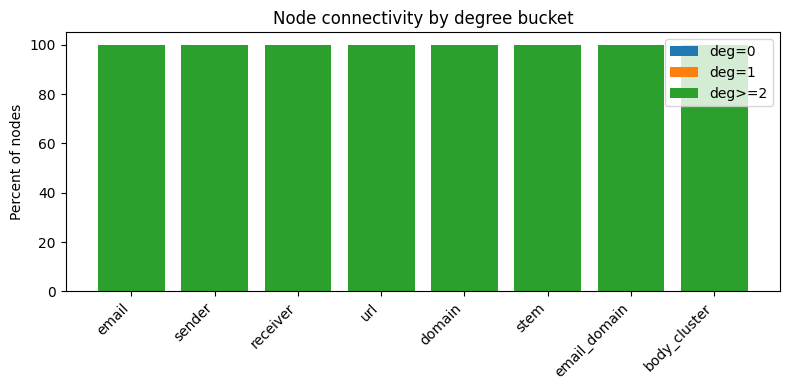

In [ ]:
from src.graph_diagnostics import summarize_relation_connectivity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT = os.path.abspath('..')
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

multi_threshold = 2
relation_rows, overall_node_stats = summarize_relation_connectivity(data, multi_threshold=multi_threshold)

rel_records = []
for row in relation_rows:
    src_type, rel, dst_type = row['edge_type']
    src_counts, dst_counts = row['src_counts'], row['dst_counts']
    src_deg0_pct = 100 - src_counts['pct_deg1'] - src_counts[f'pct_deg>={multi_threshold}']
    dst_deg0_pct = 100 - dst_counts['pct_deg1'] - dst_counts[f'pct_deg>={multi_threshold}']
    rel_records.append({
        'edge_type': f"{src_type}->{rel}->{dst_type}",
        '|E|': row['num_edges'],
        'src_deg0%': src_deg0_pct,
        'src_deg1%': src_counts['pct_deg1'],
        f'src_deg>={multi_threshold}%': src_counts[f'pct_deg>={multi_threshold}'],
        'dst_deg0%': dst_deg0_pct,
        'dst_deg1%': dst_counts['pct_deg1'],
        f'dst_deg>={multi_threshold}%': dst_counts[f'pct_deg>={multi_threshold}'],
    })
rel_df = pd.DataFrame(rel_records)
display(rel_df.round(1))
rel_df.to_csv('connectivity_relations.csv', index=False)
print('Saved per-relation connectivity to connectivity_relations.csv')

overall_records = []
for ntype, counts in overall_node_stats.items():
    total = counts['total_nodes'] or 1
    deg0_pct = counts['deg0'] / total * 100
    overall_records.append({
        'node_type': ntype,
        'deg0%': deg0_pct,
        'deg1%': counts['pct_deg1'],
        f'deg>={multi_threshold}%': counts[f'pct_deg>={multi_threshold}'],
    })
overall_df = pd.DataFrame(overall_records)
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(overall_df))
ax.bar(x, overall_df['deg0%'], label='deg=0')
ax.bar(x, overall_df['deg1%'], bottom=overall_df['deg0%'], label='deg=1')
bottom2 = overall_df['deg0%'] + overall_df['deg1%']
ax.bar(x, overall_df[f'deg>={multi_threshold}%'], bottom=bottom2, label=f'deg>={multi_threshold}')
ax.set_xticks(x)
ax.set_xticklabels(overall_df['node_type'], rotation=45, ha='right')
ax.set_ylabel('Percent of nodes')
ax.set_title('Node connectivity by degree bucket')
ax.legend()
plt.tight_layout()
plt.show()


### 1.3 Quick sanity check of the data

In [ ]:
print("=== Data loaded ===")
print("Metadata (node_types, edge_types):")
print(data.metadata())

print("\nNode counts:")
for ntype in data.node_types:
    print(f"  {ntype:>12}: {data[ntype].num_nodes}")

print("\nEdge counts:")
for et in data.edge_types:
    E = data[et].edge_index.size(1)
    print(f"  {et}: {E}")

print("\nFeature tensors present?")
for ntype in data.node_types:
    has_x = 'x' in data[ntype]
    shape = tuple(data[ntype].x.shape) if has_x else None
    print(f"  {ntype:>12}: x present? {has_x}, shape={shape}")

=== Data loaded ===
Metadata (node_types, edge_types):
(['email', 'sender', 'url', 'domain', 'stem', 'body_cluster'], [('email', 'has_sender', 'sender'), ('email', 'has_url', 'url'), ('email', 'has_domain', 'domain'), ('email', 'has_stem', 'stem'), ('email', 'has_body_cluster', 'body_cluster'), ('sender', 'rev_has_sender', 'email'), ('url', 'rev_has_url', 'email'), ('domain', 'rev_has_domain', 'email'), ('stem', 'rev_has_stem', 'email'), ('body_cluster', 'rev_has_body_cluster', 'email')])

Node counts:
         email: 28305
        sender: 11932
           url: 2613
        domain: 2769
          stem: 1225
  body_cluster: 300

Edge counts:
  ('email', 'has_sender', 'sender'): 13884
  ('email', 'has_url', 'url'): 10900
  ('email', 'has_domain', 'domain'): 18028
  ('email', 'has_stem', 'stem'): 15638
  ('email', 'has_body_cluster', 'body_cluster'): 28305
  ('sender', 'rev_has_sender', 'email'): 13884
  ('url', 'rev_has_url', 'email'): 10900
  ('domain', 'rev_has_domain', 'email'): 18028

### 1.5 Setting device and torch seed (so training and eval can be replicated)

In [ ]:
import torch
DEVICE = "mps"
print(DEVICE)
TORCH_SEED = 42


mps


In [ ]:
PRIMARY_NTYPE = 'email'
HIDDEN_DIM = 128
OUT_DIM = 128
LAYERS = 2
DROPOUT = 0.3
NEG_RATIO = 1.0
BATCH_SIZE = 256
FANOUT = FANOUT = [-1, -1]
VAL_RATIO = 0.1
TEST_RATIO = 0.1
EPOCHS = 30
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 5e-4
SCORE_HEAD = 'dot'
MODEL_SAVE_NAME = 'best_model.pt'
EARLY_STOPPING_PATIENCE = 5


In [ ]:
import os, sys
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.train import run_training


model, predictor, loaders, splits = run_training(
    DEVICE,
    TORCH_SEED,
    data,
    primary_ntype=PRIMARY_NTYPE,
    hidden=HIDDEN_DIM, out_dim=OUT_DIM, layers=LAYERS, dropout=DROPOUT,
    neg_ratio=NEG_RATIO,
    batch_size=BATCH_SIZE, fanout=FANOUT,
    val_ratio=VAL_RATIO, test_ratio=TEST_RATIO, epochs=EPOCHS, lr=LEARNING_RATE, wd=WEIGHT_DECAY,
    score_head=SCORE_HEAD,
    model_save_name=MODEL_SAVE_NAME,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
)



Metadata: (['email', 'sender', 'url', 'domain', 'stem', 'body_cluster'], [('email', 'has_sender', 'sender'), ('email', 'has_url', 'url'), ('email', 'has_domain', 'domain'), ('email', 'has_stem', 'stem'), ('email', 'has_body_cluster', 'body_cluster'), ('body_cluster', 'body_cluster_has_email', 'email'), ('sender', 'rev_has_sender', 'email'), ('url', 'rev_has_url', 'email'), ('domain', 'rev_has_domain', 'email'), ('stem', 'rev_has_stem', 'email'), ('body_cluster', 'rev_has_body_cluster', 'email'), ('email', 'rev_body_cluster_has_email', 'body_cluster')])
Supervised edge types: [('email', 'has_sender', 'sender'), ('email', 'has_url', 'url'), ('email', 'has_domain', 'domain'), ('email', 'has_stem', 'stem'), ('email', 'has_body_cluster', 'body_cluster'), ('body_cluster', 'body_cluster_has_email', 'email'), ('sender', 'rev_has_sender', 'email'), ('url', 'rev_has_url', 'email'), ('domain', 'rev_has_domain', 'email'), ('stem', 'rev_has_stem', 'email'), ('body_cluster', 'rev_has_body_cluster', 

train epoch:   6%|▌         | 44/726 [00:26<09:51,  1.15it/s]

[train] ('email', 'has_sender', 'sender'): 44 batches in 26.8s (1.64 batches/s)


train epoch:  11%|█         | 79/726 [01:04<15:57,  1.48s/it]

[train] ('email', 'has_url', 'url'): 35 batches in 37.7s (0.93 batches/s)


train epoch:  19%|█▊        | 136/726 [02:23<15:49,  1.61s/it]

[train] ('email', 'has_domain', 'domain'): 57 batches in 79.1s (0.72 batches/s)


train epoch:  25%|██▌       | 185/726 [04:06<21:48,  2.42s/it]

[train] ('email', 'has_stem', 'stem'): 49 batches in 102.5s (0.48 batches/s)


train epoch:  38%|███▊      | 274/726 [08:02<22:26,  2.98s/it]

[train] ('email', 'has_body_cluster', 'body_cluster'): 89 batches in 236.6s (0.38 batches/s)


train epoch:  50%|█████     | 363/726 [12:18<25:25,  4.20s/it]

[train] ('body_cluster', 'body_cluster_has_email', 'email'): 89 batches in 255.7s (0.35 batches/s)


train epoch:  56%|█████▌    | 407/726 [15:51<28:52,  5.43s/it]

[train] ('sender', 'rev_has_sender', 'email'): 44 batches in 213.3s (0.21 batches/s)


train epoch:  61%|██████    | 442/726 [18:48<27:33,  5.82s/it]

[train] ('url', 'rev_has_url', 'email'): 35 batches in 176.4s (0.20 batches/s)


train epoch:  69%|██████▊   | 499/726 [23:35<23:01,  6.09s/it]

[train] ('domain', 'rev_has_domain', 'email'): 57 batches in 287.8s (0.20 batches/s)


train epoch:  75%|███████▌  | 548/726 [28:08<20:46,  7.00s/it]

[train] ('stem', 'rev_has_stem', 'email'): 49 batches in 272.1s (0.18 batches/s)


train epoch:  88%|████████▊ | 637/726 [37:56<12:38,  8.52s/it]

[train] ('body_cluster', 'rev_has_body_cluster', 'email'): 89 batches in 588.7s (0.15 batches/s)


[train] ('email', 'rev_body_cluster_has_email', 'body_cluster'): 89 batches in 914.5s (0.10 batches/s)


eval epoch:   6%|▌         | 6/100 [00:44<11:56,  7.62s/it]

[eval] ('email', 'has_sender', 'sender'): 6 batches in 44.3s (0.14 batches/s)


eval epoch:  11%|█         | 11/100 [02:10<26:29, 17.86s/it]

[eval] ('email', 'has_url', 'url'): 5 batches in 86.4s (0.06 batches/s)


eval epoch:  19%|█▉        | 19/100 [03:11<09:58,  7.39s/it]

[eval] ('email', 'has_domain', 'domain'): 8 batches in 60.4s (0.13 batches/s)


eval epoch:  26%|██▌       | 26/100 [03:55<08:51,  7.18s/it]

[eval] ('email', 'has_stem', 'stem'): 7 batches in 44.3s (0.16 batches/s)


eval epoch:  38%|███▊      | 38/100 [05:29<09:01,  8.74s/it]

[eval] ('email', 'has_body_cluster', 'body_cluster'): 12 batches in 93.8s (0.13 batches/s)


eval epoch:  50%|█████     | 50/100 [06:21<04:12,  5.04s/it]

[eval] ('body_cluster', 'body_cluster_has_email', 'email'): 12 batches in 52.4s (0.23 batches/s)


eval epoch:  56%|█████▌    | 56/100 [06:56<04:35,  6.27s/it]

[eval] ('sender', 'rev_has_sender', 'email'): 6 batches in 35.3s (0.17 batches/s)


eval epoch:  61%|██████    | 61/100 [07:34<05:12,  8.00s/it]

[eval] ('url', 'rev_has_url', 'email'): 5 batches in 37.3s (0.13 batches/s)


eval epoch:  69%|██████▉   | 69/100 [11:49<24:20, 47.11s/it]

[eval] ('domain', 'rev_has_domain', 'email'): 8 batches in 255.6s (0.03 batches/s)


eval epoch:  76%|███████▌  | 76/100 [16:08<15:25, 38.55s/it]

[eval] ('stem', 'rev_has_stem', 'email'): 7 batches in 258.4s (0.03 batches/s)


eval epoch:  88%|████████▊ | 88/100 [20:19<03:20, 16.68s/it]

[eval] ('body_cluster', 'rev_has_body_cluster', 'email'): 12 batches in 251.7s (0.05 batches/s)


[eval] ('email', 'rev_body_cluster_has_email', 'body_cluster'): 12 batches in 174.6s (0.07 batches/s)
[Epoch 01] train loss 0.5326 acc 0.809 | val loss 0.5329 acc 0.806
✓ Model saved to /Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/models/best_model.pt


train epoch:   3%|▎         | 20/726 [07:41<6:51:19, 34.96s/it]

KeyboardInterrupt: 

In [ ]:
import os, sys
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.train import run_training
from src.model_io import load_model_checkpoint

model_ckpt, predictor_ckpt, checkpoint = load_model_checkpoint(
    DEVICE, metadata=data.metadata(), filename=MODEL_SAVE_NAME
)
print(f"Checkpoint ready from epoch {checkpoint['epoch']} with val loss {checkpoint['val_loss']:.4f}")

model, predictor, loaders, splits = run_training(
    DEVICE,
    TORCH_SEED,
    data,
    primary_ntype=PRIMARY_NTYPE,
    hidden=HIDDEN_DIM, out_dim=OUT_DIM, layers=LAYERS, dropout=DROPOUT,
    neg_ratio=NEG_RATIO,
    batch_size=BATCH_SIZE, fanout=FANOUT,
    val_ratio=VAL_RATIO, test_ratio=TEST_RATIO, epochs=20, lr=LEARNING_RATE, wd=WEIGHT_DECAY,
    score_head=SCORE_HEAD,
    model_save_name=MODEL_SAVE_NAME,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    resume_from=MODEL_SAVE_NAME,
)


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

Checkpoint ready from epoch 4 with val loss 0.5040
Metadata: (['email', 'sender', 'receiver', 'url'], [('email', 'has_sender', 'sender'), ('email', 'has_receiver', 'receiver'), ('email', 'has_url', 'url'), ('sender', 'rev_has_sender', 'email'), ('receiver', 'rev_has_receiver', 'email'), ('url', 'rev_has_url', 'email')])


NotImplementedError: The operator 'aten::_convert_indices_from_coo_to_csr.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.